# Fitting with time delay scan -Raise-
## Objective
1. Understand why raise model is needed
2. Fitting with raise model
3. Save and Load fitting result
4. Calculates species associated coefficent from fitting result
5. Evaluates F-test based confidence interval

In this example, we only deal with gaussian irf 

In [2]:
# import needed module
import numpy as np
import matplotlib.pyplot as plt
import TRXASprefitpack
from TRXASprefitpack import solve_seq_model, rate_eq_conv 
plt.rcParams["figure.figsize"] = (12,9)

## Version information

In [3]:
print(TRXASprefitpack.__version__)

0.7.1


## Seqential Decay Dynamics with finite raise time

In [7]:
# Generates fake experiment data
# Model: GS -> 1 -> 2 -> GS
# lifetime tau1: 200 fs (raise)
# tau2: 800 fs (decay), tau2: 10 ps (decay)
# fwhm paramter of gaussian IRF: 100 fs

tau_1 = 0.2
tau_2 = 0.8
tau_3 = 10
fwhm = 0.1

# initial condition
y0 = np.array([1, 0, 0, 0])

# set time range (mixed step)
t_seq1 = np.arange(-1, -0.5, 0.1)
t_seq2 = np.arange(-0.5, 0.5, 0.05)
t_seq3 = np.arange(0.5, 1, 0.1)
t_seq4 = np.arange(1, 10, 0.5)
t_seq5 = np.arange(10, 110, 10)

t_seq = \
    np.hstack((t_seq1, t_seq2, t_seq3, t_seq4, t_seq5))

eigval_seq, V_seq, c_seq = \
    solve_seq_model(np.array([tau_1, tau_2, tau_3]), y0)

# Now generates measured transient signal
# First and Last element is ground state

abs_1 = [0, 1, 1, 0]
abs_2 = [0, 0.5, 0.8, 0]
abs_3 = [0, -0.5, 0.7, 0]
abs_4 = [0, 0.6, 0.3, 0]

t0 = np.array([0, 0, 0, 0]) # set time zero of each scan = 0

# generate measured data

y_obs_1 = rate_eq_conv(t_seq-t0[0], fwhm, abs_1, eigval_seq, V_seq, c_seq, irf='g')
y_obs_2 = rate_eq_conv(t_seq-t0[1], fwhm, abs_2, eigval_seq, V_seq, c_seq, irf='g')
y_obs_3 = rate_eq_conv(t_seq-t0[2], fwhm, abs_3, eigval_seq, V_seq, c_seq, irf='g')
y_obs_4 = rate_eq_conv(t_seq-t0[3], fwhm, abs_4, eigval_seq, V_seq, c_seq, irf='g')

# generate random noise with (S/N = 20)

# Define noise level (S/N=20) w.r.t peak
eps_obs_1 = np.max(np.abs(y_obs_1))/20*np.ones_like(y_obs_1)
eps_obs_2 = np.max(np.abs(y_obs_2))/20*np.ones_like(y_obs_2)
eps_obs_3 = np.max(np.abs(y_obs_3))/20*np.ones_like(y_obs_3)
eps_obs_4 = np.max(np.abs(y_obs_4))/20*np.ones_like(y_obs_4)

# generate random noise
noise_1 = np.random.normal(0, eps_obs_1, t_seq.size)
noise_2 = np.random.normal(0, eps_obs_2, t_seq.size)
noise_3 = np.random.normal(0, eps_obs_3, t_seq.size)
noise_4 = np.random.normal(0, eps_obs_4, t_seq.size)


# generate measured intensity
i_obs_1 = y_obs_1 + noise_1
i_obs_2 = y_obs_2 + noise_2
i_obs_3 = y_obs_3 + noise_3
i_obs_4 = y_obs_4 + noise_4

# print real values

print('-'*24)
print(f'fwhm: {fwhm}')
print(f'tau_1: {tau_1}')
print(f'tau_2: {tau_2}')
print(f'tau_3: {tau_3}')
for i in range(4):
    print(f't_0_{i+1}: {t0[i]}')
print('-'*24)
print('Excited Species contribution')
print(f'scan 1: {abs_1[1]} \t {abs_1[2]}')
print(f'scan 2: {abs_2[1]} \t {abs_2[2]}')
print(f'scan 3: {abs_3[1]} \t {abs_3[2]}')
print(f'scan 4: {abs_4[1]} \t {abs_4[2]}')

param_exact = [fwhm, t0[0], t0[1], t0[2], t0[3], tau_1, tau_2, tau_3]

------------------------
fwhm: 0.1
tau_1: 0.2
tau_2: 0.8
tau_3: 10
t_0_1: 0
t_0_2: 0
t_0_3: 0
t_0_4: 0
------------------------
Excited Species contribution
scan 1: 1 	 1
scan 2: 0.5 	 0.8
scan 3: -0.5 	 0.7
scan 4: 0.6 	 0.3


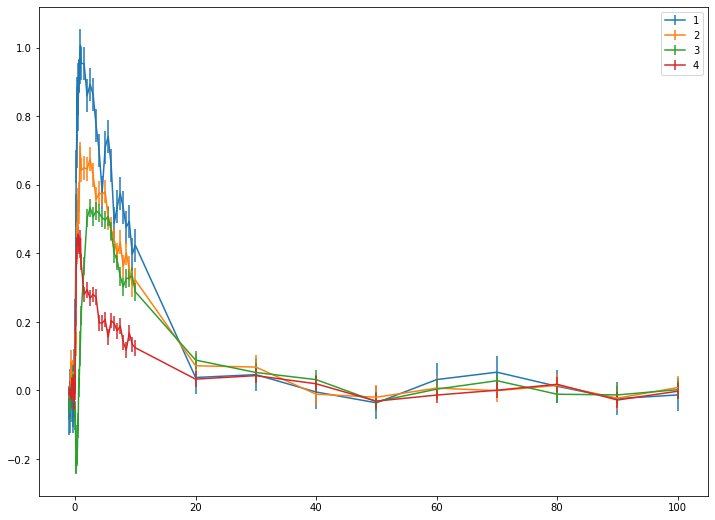

In [8]:
# plot model experimental data

plt.errorbar(t_seq, i_obs_1, eps_obs_1, label='1')
plt.errorbar(t_seq, i_obs_2, eps_obs_2, label='2')
plt.errorbar(t_seq, i_obs_3, eps_obs_3, label='3')
plt.errorbar(t_seq, i_obs_4, eps_obs_4, label='4')
plt.legend()
plt.show()

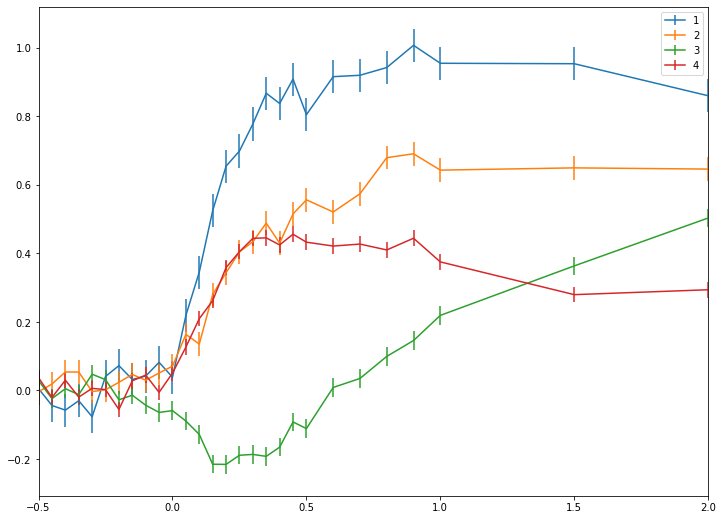

In [10]:
plt.errorbar(t_seq, i_obs_1, eps_obs_1, label='1')
plt.errorbar(t_seq, i_obs_2, eps_obs_2, label='2')
plt.errorbar(t_seq, i_obs_3, eps_obs_3, label='3')
plt.errorbar(t_seq, i_obs_4, eps_obs_4, label='4')
plt.legend()
plt.xlim(-0.5, 2)
plt.show()

Eventhough actual time zero of each time scan are exactly zero, time zero seems to be shifted when raise time is finite (or > IRF)

## Fitting with Exponential Decay model
try to fit these curve with exponential decay model with two lifetime constant

In [13]:
# import needed module for fitting
from TRXASprefitpack import fit_transient_exp

# time, intensity, eps should be sequence of numpy.ndarray
t = [t_seq] 
intensity = [np.vstack((i_obs_1, i_obs_2, i_obs_3, i_obs_4)).T]
eps = [np.vstack((eps_obs_1, eps_obs_2, eps_obs_3, eps_obs_4)).T]

# set initial guess
irf = 'g' # shape of irf function
fwhm_init = 0.2
t0_init = np.array([0, 0, 0, 0])
tau_init = np.array([1, 8])

# use global optimization method: AMPGO
fit_result_decay = fit_transient_exp(irf, fwhm_init, t0_init, tau_init, False, 
method_glb='ampgo', t=t, intensity=intensity, eps=eps)


In [14]:
# print fitting result
print(fit_result_decay)

[Model information]
    model : decay
    irf: g
    fwhm:  0.2967
    eta:  0.0000
    base: False
 
[Optimization Method]
    global: ampgo
    leastsq: trf
 
[Optimization Status]
    nfev: 3426
    status: 0
    global_opt msg: Requested Number of global iteration is finished.
    leastsq_opt msg: `ftol` termination condition is satisfied.
 
[Optimization Results]
    Total Data points: 232
    Number of effective parameters: 15
    Degree of Freedom: 217
    Chi squared:  218.6894
    Reduced chi squared:  1.0078
    AIC (Akaike Information Criterion statistic):  16.2923
    BIC (Bayesian Information Criterion statistic):  67.9934
 
[Parameters]
    fwhm_G:  0.29673709 +/-  0.01698924 ( 5.73%)
    t_0_1_1:  0.13171113 +/-  0.01061334 ( 8.06%)
    t_0_1_2:  0.12797325 +/-  0.01498910 ( 11.71%)
    t_0_1_3:  0.12142565 +/-  0.01307209 ( 10.77%)
    t_0_1_4:  0.13122098 +/-  0.00848809 ( 6.47%)
    tau_1:  1.03111027 +/-  0.06040135 ( 5.86%)
    tau_2:  9.19461651 +/-  0.39577493 ( 4

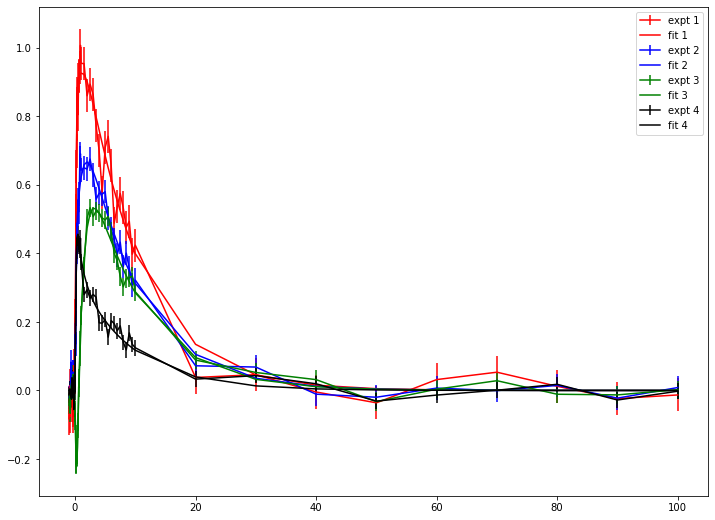

In [15]:
# plot fitting result and experimental data

color_lst = ['red', 'blue', 'green', 'black']

for i in range(4):
    plt.errorbar(t[0], intensity[0][:, i], eps[0][:, i], label=f'expt {i+1}', color=color_lst[i])
    plt.errorbar(t[0], fit_result_decay['fit'][0][:, i], label=f'fit {i+1}', color=color_lst[i])

plt.legend()
plt.show()

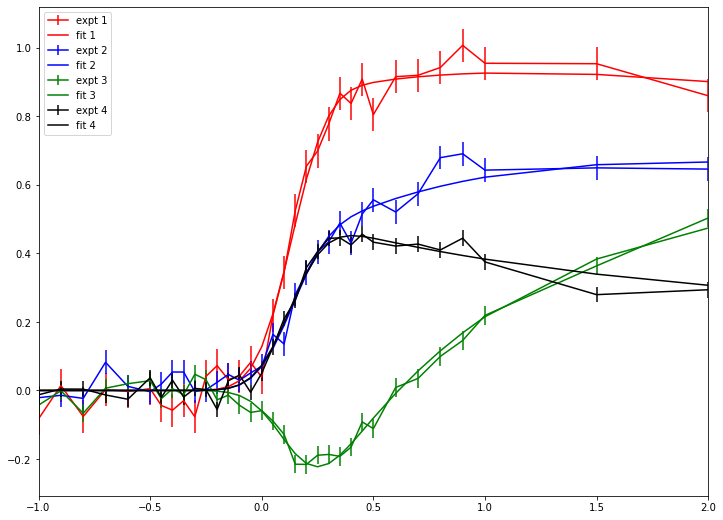

In [17]:
# plot with shorter time range

for i in range(4):
    plt.errorbar(t[0], intensity[0][:, i], eps[0][:, i], label=f'expt {i+1}', color=color_lst[i])
    plt.errorbar(t[0], fit_result_decay['fit'][0][:, i], label=f'fit {i+1}', color=color_lst[i])

plt.legend()
plt.xlim(-1, 2)
plt.show()


Exponential decay model with two lifetime constant well represent modeled time scan curve with finite raise time.
However, it gives delayed time zero (actual time zero is $0$) and broadened irf (actual irf is 100 fs).
To deal with such problem we need to consider raise model.
$\exp(-t/\tau_{i+1}) - \exp(-t/\tau_1)$.

## Fitting with Raise Model
Now include, finite raise time

In [36]:
# import needed module for fitting
from TRXASprefitpack import fit_transient_raise

# time, intensity, eps should be sequence of numpy.ndarray
t = [t_seq] 
intensity = [np.vstack((i_obs_1, i_obs_2, i_obs_3, i_obs_4)).T]
eps = [np.vstack((eps_obs_1, eps_obs_2, eps_obs_3, eps_obs_4)).T]

# set initial guess
irf = 'g' # shape of irf function
fwhm_init = 0.2
t0_init = np.array([0, 0, 0, 0])
tau_init = np.array([0.1, 1, 8])
# first tau is raise time constant

# use global optimization method: AMPGO
fit_result_raise = fit_transient_raise(irf, fwhm_init, t0_init, tau_init, False, 
method_glb='basinhopping', t=t, intensity=intensity, eps=eps)

In [37]:
# print fitting result
print(fit_result_raise)

[Model information]
    model : raise
    irf: g
    fwhm:  0.2075
    eta:  0.0000
    base: False
 
[Optimization Method]
    global: basinhopping
    leastsq: trf
 
[Optimization Status]
    nfev: 3801
    status: 0
    global_opt msg: requested number of basinhopping iterations completed successfully
    leastsq_opt msg: `ftol` termination condition is satisfied.
 
[Optimization Results]
    Total Data points: 232
    Number of effective parameters: 16
    Degree of Freedom: 216
    Chi squared:  214.0454
    Reduced chi squared:  0.991
    AIC (Akaike Information Criterion statistic):  13.3126
    BIC (Bayesian Information Criterion statistic):  68.4604
 
[Parameters]
    fwhm_G:  0.20747572 +/-  0.03488210 ( 16.81%)
    t_0_1_1:  0.03003149 +/-  0.01912220 ( 63.67%)
    t_0_1_2:  0.02587636 +/-  0.02187830 ( 84.55%)
    t_0_1_3:  0.01976275 +/-  0.02024045 ( 102.42%)
    t_0_1_4:  0.02897678 +/-  0.01796814 ( 62.01%)
    tau_1:  0.12653541 +/-  0.02802094 ( 22.14%)
    tau_2:  0.

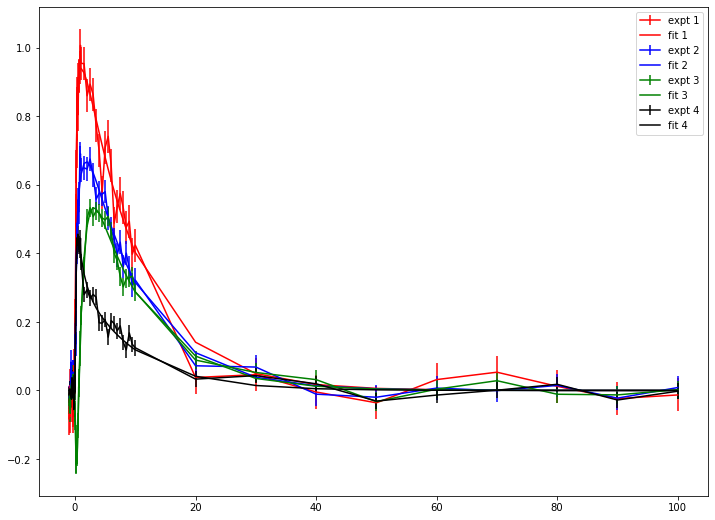

In [27]:
# plot fitting result and experimental data

color_lst = ['red', 'blue', 'green', 'black']

for i in range(4):
    plt.errorbar(t[0], intensity[0][:, i], eps[0][:, i], label=f'expt {i+1}', color=color_lst[i])
    plt.errorbar(t[0], fit_result_raise['fit'][0][:, i], label=f'fit {i+1}', color=color_lst[i])

plt.legend()
plt.show()



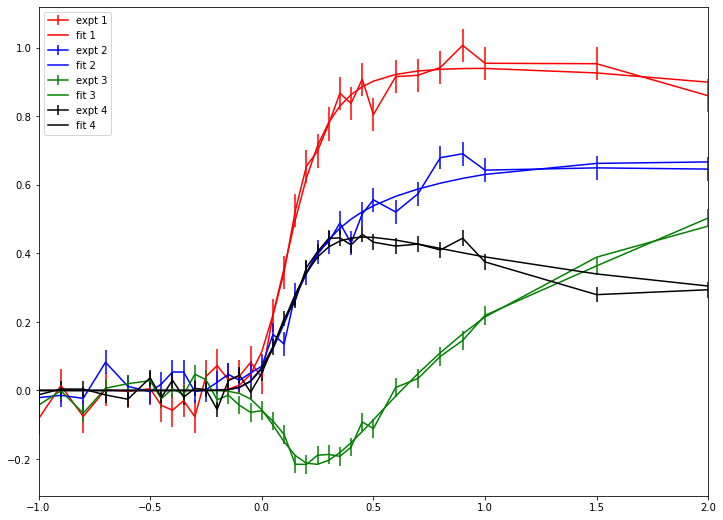

In [28]:
# plot with shorter time range

for i in range(4):
    plt.errorbar(t[0], intensity[0][:, i], eps[0][:, i], label=f'expt {i+1}', color=color_lst[i])
    plt.errorbar(t[0], fit_result_raise['fit'][0][:, i], label=f'fit {i+1}', color=color_lst[i])

plt.legend()
plt.xlim(-1, 2)
plt.show()

1. Raise model narrowed IRF than decay model (but still much broader irf than real irf)
2. Raise model correctly estimate time zero
3. Raise model gives slightly better chi squared and AIC value

In [39]:
# Compare fitting value and exact value
for i in range(len(fit_result_raise['x'])):
    print(f"{fit_result_raise['param_name'][i]}: {fit_result_raise['x'][i]} (fit) \t {param_exact[i]} (exact)")

fwhm_G: 0.20747571848013283 (fit) 	 0.1 (exact)
t_0_1_1: 0.030031486510534312 (fit) 	 0 (exact)
t_0_1_2: 0.02587636217659631 (fit) 	 0 (exact)
t_0_1_3: 0.019762752140918268 (fit) 	 0 (exact)
t_0_1_4: 0.02897678219556061 (fit) 	 0 (exact)
tau_1: 0.12653541183077882 (fit) 	 0.2 (exact)
tau_2: 0.9624692848970426 (fit) 	 0.8 (exact)
tau_3: 9.509497573594869 (fit) 	 10 (exact)


Fitting result and exact result are match well.
For future use or transfer your fitting result to your collaborator or superviser, you want to save or load fitting result from file.

In [40]:
# save fitting result to file
from TRXASprefitpack import save_TransientResult, load_TransientResult

save_TransientResult(fit_result_raise, 'example_raise') # save fitting result to example_decay_2.h5
loaded_result = load_TransientResult('example_raise') # load fitting result from example_decay_2.h5

Now deduce species associated difference coefficient from sequential decay model

In [47]:
y0 = np.array([1, 0, 0, 0]) # initial cond
eigval, V, c = solve_seq_model(loaded_result['x'][5:], y0)

# compute scaled V matrix
V_scale = np.einsum('j,ij->ij', c, V)
diff_abs_fit = np.linalg.solve(V_scale[1:-1, 1:-1].T, loaded_result['c'][0]) 
# slice first last column and row corresponding to ground state

# compare with exact result
print('-'*24)
print('[Species Associated Difference Coefficent]')
print('scan # \t ex 1 (fit) \t ex 1 (exact) \t ex 2 (fit) \t ex 2 (exact)')
print(f'1 \t {diff_abs_fit[0,0]} \t {abs_1[1]}  \t {diff_abs_fit[1,0]} \t {abs_1[2]}')
print(f'2 \t {diff_abs_fit[0,1]} \t {abs_2[1]}  \t {diff_abs_fit[1,1]} \t {abs_2[2]}')
print(f'3 \t {diff_abs_fit[0,2]} \t {abs_3[1]}  \t {diff_abs_fit[1,2]} \t {abs_3[2]}')
print(f'4 \t {diff_abs_fit[0,3]} \t {abs_4[1]}  \t {diff_abs_fit[1,3]} \t {abs_4[2]}')


------------------------
[Species Associated Difference Coefficent]
scan # 	 ex 1 (fit) 	 ex 1 (exact) 	 ex 2 (fit) 	 ex 2 (exact)
1 	 0.9026888745602233 	 1  	 1.0188033936190266 	 1
2 	 0.4557933596036181 	 0.5  	 0.7976595103990074 	 0.8
3 	 -0.4489902658360139 	 -0.5  	 0.7264435792721703 	 0.7
4 	 0.5345334988765447 	 0.6  	 0.29962736403171697 	 0.3


It also matches well, as expected.

The error of paramter reported from `Transient` Driver is based on Asymptotic Standard Error.
However, strictly, ASE cannot be used in non-linear regression.
TRXASprefitpack provides alternative error estimation based on `F-test`.

In [48]:
from TRXASprefitpack import confidence_interval

ci_result = confidence_interval(loaded_result, 0.05) # set significant level: 0.05 -> 95% confidence level
print(ci_result) # report confidence interval

[Report for Confidence Interval]
    Method: f
    Significance level:  5.000000e-02
 
[Confidence interval]
    0.20747572 -  0.0690065 <= fwhm_G <=  0.20747572 +  0.07688048
    0.03003149 -  0.03228349 <= t_0_1_1 <=  0.03003149 +  0.05652076
    0.02587636 -  0.0424996 <= t_0_1_2 <=  0.02587636 +  0.05881277
    0.01976275 -  0.03797883 <= t_0_1_3 <=  0.01976275 +  0.05762098
    0.02897678 -  0.03019816 <= t_0_1_4 <=  0.02897678 +  0.05646796
    0.12653541 -  0.0779238 <= tau_1 <=  0.12653541 +  0.05457845
    0.96246928 -  0.12961034 <= tau_2 <=  0.96246928 +  0.13806957
    9.50949757 -  0.80336036 <= tau_3 <=  9.50949757 +  0.8699603


In [49]:
# compare with ase
from scipy.stats import norm

factor = norm.ppf(1-0.05/2)

print('[Confidence interval (from ASE)]')
for i in range(loaded_result['param_name'].size):
    print(f"{loaded_result['x'][i] :.8f} - {factor*loaded_result['x_eps'][i] :.8f}", 
          f"<= {loaded_result['param_name'][i]} <=", f"{loaded_result['x'][i] :.8f} + {factor*loaded_result['x_eps'][i] :.8f}")

[Confidence interval (from ASE)]
0.20747572 - 0.06836765 <= fwhm_G <= 0.20747572 + 0.06836765
0.03003149 - 0.03747882 <= t_0_1_1 <= 0.03003149 + 0.03747882
0.02587636 - 0.04288068 <= t_0_1_2 <= 0.02587636 + 0.04288068
0.01976275 - 0.03967055 <= t_0_1_3 <= 0.01976275 + 0.03967055
0.02897678 - 0.03521690 <= t_0_1_4 <= 0.02897678 + 0.03521690
0.12653541 - 0.05492003 <= tau_1 <= 0.12653541 + 0.05492003
0.96246928 - 0.12923182 <= tau_2 <= 0.96246928 + 0.12923182
9.50949757 - 0.82960559 <= tau_3 <= 9.50949757 + 0.82960559


However, as you can see, in many case, ASE does not much different from more sophisticated `f-test` based error estimation.